# exp023

In [1]:
import os
import sys
import gc
import itertools
import datetime
from dateutil.relativedelta import relativedelta
from dotenv import load_dotenv
load_dotenv()
sys.path.append(os.getenv('UTILS_PATH'))

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

import line_notify

In [2]:
import builtins
import types

def imports():
    for name, val in globals().items():
        # module imports
        if isinstance(val, types.ModuleType):
            yield name, val

            # functions / callables
        if hasattr(val, '__call__'):
            yield name, val


def noglobal(f):
    '''
    ref: https://gist.github.com/raven38/4e4c3c7a179283c441f575d6e375510c
    '''
    return types.FunctionType(f.__code__,
                              dict(imports()),
                              f.__name__,
                              f.__defaults__,
                              f.__closure__
                              )

In [3]:
def apk(y_true, y_pred, K=12):
    assert(len(y_true) == len(y_pred))
    apks = []
    for idx in range(len(y_true)):
        y_i_true = y_true[idx]
        y_i_pred = y_pred[idx]

        if not y_i_pred == y_i_pred:
            y_i_pred = []

        # 予測値の数と重複の確認
        assert(len(y_i_pred) <= K)
        assert(len(np.unique(y_i_pred)) == len(y_i_pred))

        sum_precision = 0.0
        num_hits = 0.0

        for i, p in enumerate(y_i_pred):
            if p in y_i_true:
                num_hits += 1
                precision = num_hits / (i+1)
                sum_precision += precision
        apk = sum_precision / min(len(y_i_true), K)
        apks.append(apk)
    return apks

In [4]:
def cover_rate(y_true, y_pred):
    assert(len(y_true) == len(y_pred))
    num_true = 0
    num_hits = 0
    for idx in range(len(y_true)):
        y_i_true = y_true[idx]
        y_i_pred = y_pred[idx]

        if not y_i_pred == y_i_pred:
            y_i_pred = []

        num_true += len(y_i_true)
        num_hits += len(list(set(y_i_true) & set(y_i_pred)))

    return num_hits / num_true

In [5]:
SEED = 42

ディレクトリ設定

In [6]:
INPUT_DIR = os.getenv('INPUT_DIR')
OUTPUT_DIR = os.getenv('OUTPUT_DIR')
#exp_name = os.path.dirname(__file__).split('/')[-1]
exp_name = 'exp023'
os.makedirs(OUTPUT_DIR + exp_name, exist_ok=True)

データ読み込み

In [7]:
articles = pd.read_csv(INPUT_DIR + 'articles.csv', dtype='object')
customers = pd.read_csv(INPUT_DIR + 'customers.csv')
transactions = pd.read_csv(INPUT_DIR + 'transactions_train.csv', dtype={'article_id':'str'}, parse_dates=['t_dat'])
sample = pd.read_csv(INPUT_DIR + 'sample_submission.csv')

# 前処理

In [8]:
ALL_CUSTOMER = customers['customer_id'].unique().tolist()
ALL_ARTICLE = articles['article_id'].unique().tolist()

customer_ids = dict(list(enumerate(ALL_CUSTOMER)))
article_ids = dict(list(enumerate(ALL_ARTICLE)))

customer_map = {u: uidx for uidx, u in customer_ids.items()}
article_map = {i: iidx for iidx, i in article_ids.items()}

articles['article_id'] = articles['article_id'].map(article_map)
customers['customer_id'] = customers['customer_id'].map(customer_map)
transactions['article_id'] = transactions['article_id'].map(article_map)
transactions['customer_id'] = transactions['customer_id'].map(customer_map)
sample['customer_id'] = sample['customer_id'].map(customer_map)

In [9]:
# 名寄せ
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].str.replace('None','NONE')
# transactionに紐づけ
transactions = transactions.merge(customers, on='customer_id', how='left')
transactions = transactions.merge(articles, on='article_id', how='left')

# データセット作成（レコメンド→対象データセット作成→特徴量エンジニアリング）

In [10]:
class Recommender:
    @noglobal
    def __init__(self, history, target_customer_id, valid=None):
        self.history = history
        self.valid = valid
        self.target_customer_id = target_customer_id

        if self.valid is not None:
            self.valid_true = self.valid[['customer_id', 'article_id']].drop_duplicates()
            self.valid_true = self.valid_true.groupby('customer_id')['article_id'].apply(list).reset_index()
            self.valid_true = self.valid_true.sort_values('customer_id').reset_index(drop=True)
            self.valid_true = self.valid_true.rename(columns={'article_id':'true'})
        else:
            self.valid_true = None
    
    @noglobal
    def customer_frequent(self, n=12, timedelta=None):
        df = self.history.copy()
        if timedelta is not None:
            st_date = df['t_dat'].max() - timedelta
            df = df[df['t_dat']>=st_date].copy()
        
        customer_agg = df.groupby(['customer_id', 'article_id'])['t_dat'].count().reset_index()
        customer_agg = customer_agg.rename(columns={'t_dat':'cnt'})
        customer_agg = customer_agg.sort_values(['customer_id', 'cnt'], ascending=False)
        result = customer_agg.groupby('customer_id').head(n)
        result = result[result['customer_id'].isin(self.target_customer_id)].copy()
        return result[['customer_id', 'article_id']]

    @noglobal
    def popular_article(self, n=12, timedelta=None, data_filter=None):
        df = self.history.copy()
        if timedelta is not None:
            st_date = df['t_dat'].max() - timedelta
            df = df[df['t_dat']>=st_date].copy()

        if data_filter is not None:
            c = list(data_filter.keys())[0]
            v = list(data_filter.values())[0]
            df = df[df[c]==v].copy()

        total_agg = df.groupby('article_id')['t_dat'].count().reset_index()
        total_agg = total_agg.rename(columns={'t_dat':'cnt'})
        total_agg = total_agg.sort_values(['cnt'], ascending=False)
        total_agg = total_agg.head(n)
        popular_articles = list(total_agg['article_id'].values)
        result = pd.DataFrame(itertools.product(self.target_customer_id, popular_articles), columns=['customer_id', 'article_id'])
        return result

    @noglobal
    def calc_mapk(self, valid_pred):
        valid_pred = valid_pred.groupby('customer_id')['article_id'].apply(list).reset_index()
        df = self.valid_true.merge(valid_pred, on='customer_id', how='left')
        score = np.mean(apk(df['true'].tolist(), df['article_id'].tolist()))
        return score

    def calc_cover_rate(self, valid_pred):
        valid_pred = valid_pred.groupby('customer_id')['article_id'].apply(list).reset_index()
        df = self.valid_true.merge(valid_pred, on='customer_id', how='left')
        score = cover_rate(df['true'].tolist(), df['article_id'].tolist())
        return score


    @noglobal
    def add(self, result, new, name='new_rec'):
        result = result.append(new)
        result = result.drop_duplicates()

        if self.valid_true is not None:
            mapk = self.calc_mapk(new)
            print(f'{name}_mp@12 : ' + '{:.5f}'.format(mapk))

            cover_rate = self.calc_cover_rate(result)
            print(f'現時点のカバー率 : ' + '{:.5f}'.format(cover_rate))

        return result

    @noglobal
    def get(self):
        result = pd.DataFrame()

        tds = [None, relativedelta(weeks=1), relativedelta(months=1), relativedelta(years=1)]
        td_strs = ['全期間', '直近1week', '直近1month', '直近1year']
        for td, td_str in zip(tds, td_strs):
            result = self.add(result, self.popular_article(timedelta=td), f'全体の最頻値({td_str}))')
            result = self.add(result, self.customer_frequent(timedelta=td), f'顧客ごと最頻値({td_str})')
            
        for group in ['Menswear']:
            result = self.add(result, self.popular_article(timedelta=relativedelta(weeks=1), 
                              data_filter={'index_group_name':group}), f'{group}の最頻値(直近1week)))')
        
        result = result[result['customer_id'].isin(self.target_customer_id)].copy()
        return result



In [11]:
@noglobal
def add_labels(recom_result, history):
    """レコメンドしたデータが学習期間で購入されたかどうかのフラグを付与する

    Args:
        recom_result (_type_): レコメンド結果
        train_tran (_type_): 学習期間のトランザクションデータ

    Returns:
        _type_: 学習期間での購入フラグを付与したレコメンド結果
    """
    history = history[['customer_id', 'article_id']].drop_duplicates()
    history['buy'] = 1
    recom_result = recom_result.merge(history, on=['customer_id', 'article_id'], how='left')
    recom_result['buy'] = recom_result['buy'].fillna(0)
    return recom_result


In [12]:
@noglobal
def make_article_features(articles):
    le_cols = ['product_type_name', 'product_group_name', 'graphical_appearance_name',
               'colour_group_name', 'perceived_colour_value_name', 'department_name',
               'index_name', 'index_group_name', 'section_name', 'garment_group_name']
    for c in le_cols:
        le = LabelEncoder()
        articles[c] = le.fit_transform(articles[c].fillna(''))
    return articles[['article_id']+le_cols]

@noglobal
def make_article_tran_features(history):
    df = history.groupby('article_id').agg({'t_dat':['count', 'max', 'min'],
                                            'price':['max', 'min', 'mean'], 
                                            'age':['max', 'min', 'mean', 'std']}).reset_index()
    df.columns = ['article_id','article_total_cnt', 'article_total_latest_buy', 'article_total_1st_buy', 'article_price_max', 'article_price_min', 'article_price_mean', 'article_age_max', 'article_age_min', 'article_age_mean', 'article_age_std']
    df['article_total_1st_buy'] = (history['t_dat'].max() - df['article_total_1st_buy']).dt.days
    df['article_total_latest_buy'] = (history['t_dat'].max() - df['article_total_latest_buy']).dt.days
    return df


@noglobal
def make_customer_features(customers):
    le_cols = ['club_member_status', 'fashion_news_frequency', 'postal_code']
    for c in le_cols:
        le = LabelEncoder()
        customers[c] = le.fit_transform(customers[c].fillna(''))
    return customers

@noglobal
def make_customer_tran_features(history):
    group = ['Ladieswear', 'Divided', 'Menswear', 'Sport', 'Baby/Children']
    for g in group:
        history[g] = 0
        history.loc[history['index_group_name']==g, g] = 1


    df = history.groupby('customer_id').agg({'t_dat':['count', 'max', 'min'],
                                            'price':['max', 'min', 'mean'],
                                            'Ladieswear':'sum',
                                            'Divided':'sum',
                                            'Menswear':'sum',
                                            'Sport':'sum',
                                            'Baby/Children':'sum'}).reset_index()
    df.columns = ['customer_id','customer_total_cnt', 'customer_total_latest_buy', 'customer_total_1st_buy', 
                  'customer_price_max', 'customer_price_min', 'customer_price_mean',
                  'Ladieswear', 'Divided', 'Menswear', 'Sport', 'Baby/Children']
    df['customer_total_1st_buy'] = (history['t_dat'].max() - df['customer_total_1st_buy']).dt.days
    df['customer_total_latest_buy'] = (history['t_dat'].max() - df['customer_total_latest_buy']).dt.days

    for g in group:
        df[g] = df[g] / df['customer_total_cnt']
    return df

@noglobal
def make_customer_article_features(target, history):
    df = target.merge(history, on=['customer_id', 'article_id'], how='inner')
    df = df.groupby(['customer_id', 'article_id']).agg({'t_dat':['count', 'min', 'max']}).reset_index()
    df.columns = ['customer_id', 'article_id', 'count', '1st_buy_date_diff', 'latest_buy_date_diff']
    df['1st_buy_date_diff'] = (history['t_dat'].max() - df['1st_buy_date_diff']).dt.days
    df['latest_buy_date_diff'] = (history['t_dat'].max() - df['latest_buy_date_diff']).dt.days
    return df

@noglobal
def add_features(df, history, articles, customers):
    article_features = make_article_features(articles)
    article_tran_features = make_article_tran_features(history)
    customer_features = make_customer_features(customers)
    customer_tran_features = make_customer_tran_features(history)
    customer_article_features = make_customer_article_features(df[['customer_id', 'article_id']], history)

    df = df.merge(article_features, on=['article_id'], how='left')
    df = df.merge(article_tran_features, on=['article_id'], how='left')
    df = df.merge(customer_features, on=['customer_id'], how='left')
    df = df.merge(customer_tran_features, on=['customer_id'], how='left')
    df = df.merge(customer_article_features, on=['article_id', 'customer_id'], how='left')
    return df
    

# レコメンド商品を購入するかどうかの2値分類モデル

In [13]:
params = {
    "objective": "binary",
    "boosting" : "gbdt",
    "learning_rate": 0.1,
    "metric": "binary_logloss",
    "seed": SEED
}

In [14]:
# 1週ずつローリングして学習データを生成し検証
n_iter = 3
train_start = datetime.datetime(2020,9,9)
valid_start = datetime.datetime(2020,9,16)
valid_end = datetime.datetime(2020,9,22)

fi = pd.DataFrame()
scores = []
models = []
for i in range(n_iter):
    print(f'{valid_start.strftime("%Y-%m-%d")} - {valid_end.strftime("%Y-%m-%d")}')
    
    # 学習データの作成
    history_tran = transactions[transactions['t_dat'] < train_start].copy()
    target_tran = transactions[(transactions['t_dat'] >= train_start) & (transactions['t_dat'] < valid_start)].copy()
    target_id = target_tran['customer_id'].unique().tolist()
    recommender = Recommender(history_tran, target_id)
    recom = recommender.get()
    ml_train = add_labels(recom, target_tran)
    ml_train = add_features(ml_train, history_tran, articles, customers)

    # 評価データの作成
    history_tran = transactions[transactions['t_dat'] < valid_start].copy()
    target_tran = transactions[(transactions['t_dat'] >= valid_start) & (transactions['t_dat'] <= valid_end)].copy()
    target_id = target_tran['customer_id'].unique().tolist()
    recommender = Recommender(history_tran, target_id, target_tran)
    recom = recommender.get()
    ml_valid = add_labels(recom, target_tran)
    ml_valid = add_features(ml_valid, history_tran, articles, customers)

    print(f'train_size : {len(ml_train)}  valid_size : {len(ml_valid)}')

    target = 'buy'
    not_use_cols = ['customer_id', 'article_id', target]
    features = [c for c in ml_train.columns if c not in not_use_cols]

    # 学習
    tr_x, tr_y = ml_train[features], ml_train[target]
    vl_x, vl_y = ml_valid[features], ml_valid[target]
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)
    model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                    num_boost_round=20000, early_stopping_rounds=100,verbose_eval=1000)

    # 特徴量重要度
    fi_tmp = pd.DataFrame()
    fi_tmp['feature'] = model.feature_name()
    fi_tmp['importance'] = model.feature_importance(importance_type='gain')
    fi_tmp['iter'] = i
    fi = fi.append(fi_tmp)

    # cv
    vl_pred = model.predict(vl_x, num_iteration=model.best_iteration)
    # 正解データ作成
    valid = transactions[(transactions['t_dat'] >= valid_start) & (transactions['t_dat'] <= valid_end)].copy()
    valid = valid[['customer_id', 'article_id']].drop_duplicates()
    valid = valid.groupby('customer_id')['article_id'].apply(list).reset_index()
    valid = valid.sort_values('customer_id').reset_index(drop=True)
    # 2値分類の出力を元に12個選定
    valid_pred = ml_valid[['customer_id', 'article_id']].copy()
    valid_pred['prob'] = vl_pred
    valid_pred = valid_pred.sort_values(['customer_id', 'prob'], ascending=False)
    valid_pred = valid_pred.groupby('customer_id').head(12)
    valid_pred = valid_pred.groupby('customer_id')['article_id'].apply(list).reset_index()
    valid_pred = valid_pred.sort_values('customer_id').reset_index(drop=True)
    assert(valid['customer_id'].tolist() == valid_pred['customer_id'].tolist())
    # MAP@12
    score = np.mean(apk(valid['article_id'].tolist(), valid_pred['article_id'].tolist()))
    print(f'{valid_start.strftime("%Y-%m-%d")} - {valid_end.strftime("%Y-%m-%d")} : ' + '{:.5f}'.format(score))
    scores.append(score)
    
    models.append(model)
    
    train_start = train_start - relativedelta(days=7)
    valid_start = valid_start - relativedelta(days=7)
    valid_end = valid_end - relativedelta(days=7)
cv_score = np.mean(scores)
print(f'MAP@12 : ' + '{:.5f}'.format(cv_score))

2020-09-16 - 2020-09-22
全体の最頻値(全期間))_mp@12 : 0.00290
現時点のカバー率 : 0.00765
顧客ごと最頻値(全期間)_mp@12 : 0.00863
現時点のカバー率 : 0.02010
全体の最頻値(直近1week))_mp@12 : 0.00874
現時点のカバー率 : 0.04070
顧客ごと最頻値(直近1week)_mp@12 : 0.01479
現時点のカバー率 : 0.05132
全体の最頻値(直近1month))_mp@12 : 0.00540
現時点のカバー率 : 0.06075
顧客ごと最頻値(直近1month)_mp@12 : 0.01752
現時点のカバー率 : 0.06543
全体の最頻値(直近1year))_mp@12 : 0.00291
現時点のカバー率 : 0.06617
顧客ごと最頻値(直近1year)_mp@12 : 0.01074
現時点のカバー率 : 0.06805
Menswearの最頻値(直近1week)))_mp@12 : 0.00260
現時点のカバー率 : 0.07416
train_size : 3851256  valid_size : 4092814


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 14563, number of negative: 3836693
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.146435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6133
[LightGBM] [Info] Number of data points in the train set: 3851256, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003781 -> initscore=-5.573882
[LightGBM] [Info] Start training from score -5.573882
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.0206531	valid_1's binary_logloss: 0.0223429
2020-09-16 - 2020-09-22 : 0.02929
2020-09-09 - 2020-09-15
全体の最頻値(全期間))_mp@12 : 0.00344
現時点のカバー率 : 0.00888
顧客ごと最頻値(全期間)_mp@12 : 0.00855
現時点のカバー率 : 0.02135
全体の最頻値(直近1week))_mp@12 : 0.00677
現時点のカバー率 : 0.03848
顧客ごと最頻値(直近1week)_mp@12 : 0.01493
現時点のカバー率 : 0.04941
全体

In [15]:
scores

[0.029289020157610625, 0.02919451730155573, 0.02897911501920788]

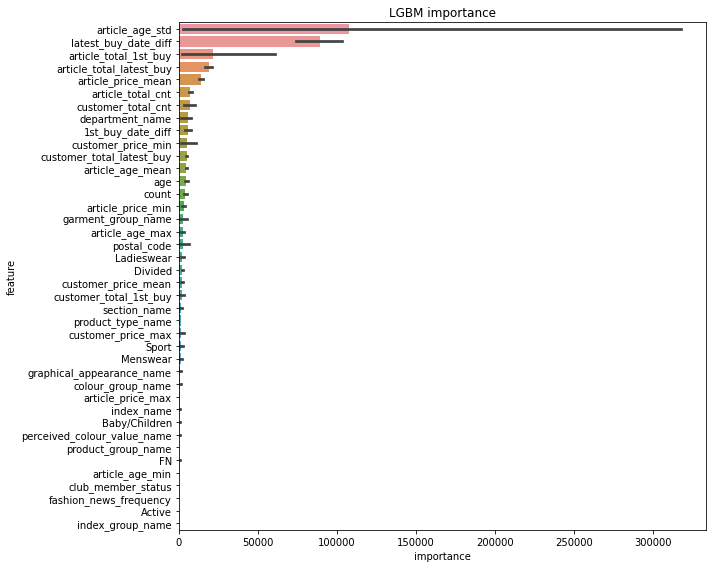

In [16]:
fi_n = fi['feature'].nunique()
order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, fi_n*0.2))
sns.barplot(x="importance", y="feature", data=fi, order=order)
plt.title(f"LGBM importance")
plt.tight_layout()
plt.savefig(OUTPUT_DIR + f'{exp_name}/lgbm_importance.png')

In [17]:
del history_tran, target_tran, ml_train, ml_valid, model
gc.collect() 

10535

# sub

In [18]:
# テストデータの作成
target_id = sample['customer_id'].tolist()
recommender = Recommender(transactions, target_id)
recom = recommender.get()
ml_test = add_features(recom, transactions, articles, customers)
test_pred = np.zeros(len(ml_test))

In [19]:
for model in models:
    test_pred += model.predict(ml_test[features], num_iteration=model.best_iteration) / n_iter

MemoryError: Unable to allocate 21.5 GiB for an array with shape (40, 72154726) and data type float64

In [ ]:
del models, recommender
gc.collect()

In [ ]:
# 2値分類の出力を元に12個選定
test = ml_test[['customer_id', 'article_id']].copy()
test['prob'] = test_pred
test = test.sort_values(['customer_id', 'prob'], ascending=False)
test = test.groupby('customer_id').head(12)

test['article_id'] = test['article_id'].map(article_ids)
test['customer_id'] = test['customer_id'].map(customer_ids)

test = test.groupby('customer_id')['article_id'].apply(list).reset_index()

In [ ]:
sub = sample['customer_id'].map(customer_ids).to_frame()
sub = sub.merge(test, on=['customer_id'], how='left')
sub = sub.rename(columns={'article_id':'prediction'})
assert(sub['prediction'].apply(len).min()==12)
sub['prediction'] = sub['prediction'].apply(lambda x: ' '.join(x))
sub.to_csv(OUTPUT_DIR + f'{exp_name}/{exp_name}_sub.csv', index=False)
sub.head()

In [ ]:
message = f'{exp_name} is finished!\nvalid_score : {cv_score}'
line_notify.send(message)